# An introduction to EUSEDcollab and user tutorial

A great level of gratitude is owed to all contributors of data from across Europe who have contributed their data coming from the hard work and efforts required to operate the numerous monitoring stations. Behind each dataset is many hours of labour and costs associated with establishing and maintaining the measuring equipment. EUSEDcollab is a data collection exercise that brings together as much data as possible through the EU Soil Observatory via the working group on soil erosion. The ultimate goal is to facilitate mutual benefits within the research community through increasing open-data availability. 

This notebook provides some simple examples of how to read the EUSEDcollab repository and perform some calculations with the data. These operations include: 1) reading a compiled metadata file to get insights into the summary statistics of the database, 2) performing calculations on the time series data to get summery level statistics on sediment yield and water discharge, and 3) reading and plotting a time series file for an individual catchment of interest. These snippets of python code are also intended to get users started in creating some of their own analyses and modelling efforts with the data.

The plots created in this notebook are those presented in the manuscript publication through which some basic operations that can be undertaken on the database can be evidenced.

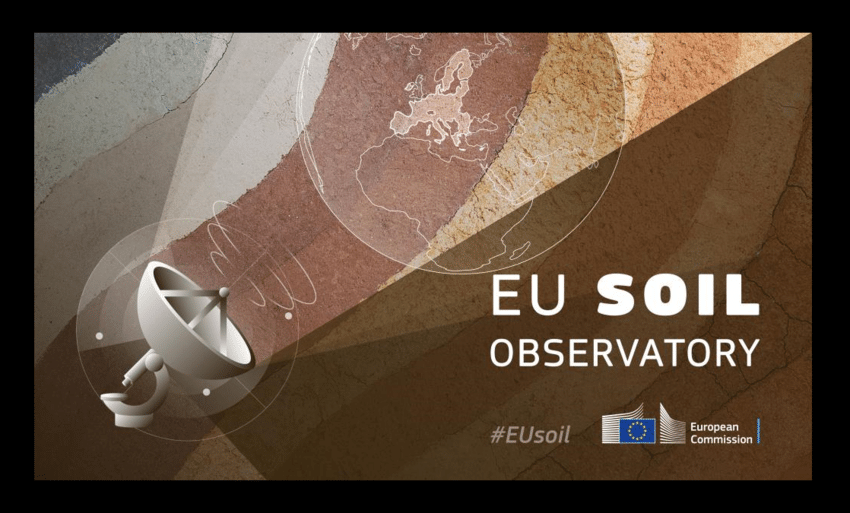

# Getting started: reading in some libraries and custom functions

We start with importing some common python libraries and some custom functions to perform operations on the database.

In [14]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import json
%matplotlib inline

To start, we define some functions that can be applied on the EUSEDcollab database. The first is a basic function to get all of the unique years contained in the database. This allows a total count of the number of entries covering a particular year to be made

In [15]:
def get_n_unique_years(md_all):
    '''
    Produce an array with all unique years in the database. E.g. if a record 
    starts in 2000 and ends in 2010, an integer is produced for each year 
    between the range. This is done for the whole database so that the number of
    entries for each unique year can be calculated.

    Parameters
    ----------
    md_all : DATAFRAME
        The dataframe with the full metadata table  of EUSEDcollab

    Returns
    -------
    List
    An array with all unique years for the entire EUSEDcollab database

    '''
    years_all = []
    for i in np.arange(len(md_all)):
        y1 = md_all['Start year'].values[i]
        y2 = md_all['End year'].values[i]
        #create an array of years between start and end
        years = np.arange(y1, y2 + 1, 1)
        years_all.extend(years)
    
    unique_years = pd.DataFrame(years_all, columns = ['year'])
    return unique_years 

Define a function to return some average annual quantifications for each time series input. This gives a relatively simple example of how we can extract annual average sediment yields from the data time series while taking into account the completeness of each record (e.g. removing years in which there are an insufficient number of data points).

In [16]:
def get_avg_y_vals(ts_path, d_format, min_completeness):
    '''
    Get summary statistics (annual average values) of a time series entry 
    of EUSEDcollab. The function returns quantifications of 'SedY_med t yr-1', 
    'SedY_mean t yr-1', 'SedY_CV', 'Q_med m3 yr-1','Q_mean m3 yr-1','n_years_in_avg'
    to summarise each time series. A minimum completeness is required to remove years
    from the average that contained an insufficient number of data points.

    Parameters
    ----------
    ts_path : STRING
        The path to the csv file with the time series entry of EUSEDcollab
    d_format : STRING
        The data time series type
    min_completeness : INTEGER
        The minimum % completeness of the data entries for each year to include
        in the average.

    Returns
    -------
    Dictionary
        A dictionary with quantifications and their names
    '''
    #read time series based on provided csv path
    ts = pd.read_csv(ts_path)
    #find the relevant columns and assign the to variables
    for col in ts.columns:
        if 'SSL' in col:
            sed_y_col = col
        if 'Q' in col and 'max' not in col:
            Q_col = col
        if 'date' in col:
           date_col = col
        elif 'Date' in col:
            date_col= col
            
    #set the dataframe index to the datetime column
    ts = ts.set_index(pd.to_datetime(ts[date_col]))
        
    #Make an initial evaluation of the number of nan values in the time series 
    #if it is exceeds 50%, skip the record
    
    pcnt_missing = (ts[sed_y_col].isna().sum() / len(ts)) * 100
    if pcnt_missing  > 50:
        skip_ts = True
    else:
        skip_ts = False
        
    #do calculations if time series is sufficiently complete for annual average stats
    if skip_ts == False:
        #resample the dataframe based on the annual sum
        ts_y = ts.resample('Y').sum()
        
        #define the data formats that are fixed. With these we can determine 
        #how complete the each year is
        fixed_formats = ['Daily data - fixed timestep', 'Monthly data']
        #if data is a fixed timestep format we can disclude years with insufficient data
        if any(d_format in x  for x in fixed_formats):
            ts_y_count = ts.resample('Y').count().rename(columns = {sed_y_col: 'Count'})
            ts_y = ts_y.merge(ts_y_count['Count'], left_index = True, right_index = True)
            if d_format == 'Daily data - fixed timestep':
                ts_y['%_complete'] = ts_y['Count']/365 * 100
            elif d_format == 'Monthly data':
                ts_y['%_complete'] = ts_y['Count']/12 * 100
            ts_y = ts_y[ts_y['%_complete'] > min_completeness]
        
          
        #get some annual average values from the timeseries
        #convert sediment values to tonnes 
        sed_yield_med_t = ts_y[sed_y_col].median()/1000
        sed_yield_mean_t = ts_y[sed_y_col].mean()/1000
        ssy_yield_min_t = ts_y[sed_y_col].min()/1000
        ssy_yield_max_t = ts_y[sed_y_col].max()/1000
        
        #get the coefficient of variation 
        sed_yield_cv = ts_y[sed_y_col].std() / ts_y[sed_y_col].mean()
        
        Q_y_med_m3 = ts_y[Q_col].median()
        Q_y_mean_m3 = ts_y[Q_col].mean()

        #get the number of years included in the average
        n_years = ts_y[sed_y_col].count()
    #time series has many nan values, assign nan values to results
    else:
        sed_yield_med_t = sed_yield_mean_t = sed_yield_cv = Q_y_med_m3 = Q_y_mean_m3 = n_years = ssy_yield_min_t = ssy_yield_max_t = np.nan
    #create 2 lists with results and variable names
    vals = [sed_yield_med_t, sed_yield_mean_t, sed_yield_cv, Q_y_med_m3, Q_y_mean_m3, 
            n_years, ssy_yield_min_t, ssy_yield_max_t]
    cols = ['SedY_med t yr-1', 'SedY_mean t yr-1', 'SedY_CV', 'Q_med m3 yr-1',
            'Q_mean m3 yr-1','N years in avg', 'SedY_min t yr-1', 
            'SedY_max t yr-1']
    
    #combine lists into a dictionary to return from function
    results = dict(zip(cols, vals))
    
    return results


Define some plotting functions to be able to create some summary-level plots of the EUSEDcollab database. These two functions give overviews of the relationships between: 1) the specific annual average sediment yield as a function of the catchment area, and 2) the annual average sediment yield as a function of the annual average discharge.

In [17]:
def plot_sedY_vs_area(md_all, colour_var):
    
    xvar = 'Drainage area km2'
    yvar = 'SedY_mean t km-2 yr-1'
    

    f, ax = plt.subplots(figsize=(15, 10))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(data = md_all, x = xvar, y = yvar, 
                        hue = colour_var, size = colour_var, sizes=(20, 300), ax = ax)

    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Specific sediment yield (t $\mathregular{km^{-2}}$ $\mathregular{yr^{-1}}$)')
    ax.set_xlabel('Catchment drainage area ($\mathregular{km^{2}}$)')
    #ax.grid(False)
    plt.legend(title='N years in average') #labels=['<= 5', '<= 10', '<= 15', '<= 25', '<= 30'])

  
def plot_sedY_vs_Q(md_all, colour_var, size_var, export = False, export_path = None):
    
    xvar = 'Q_mean m3 yr-1'
    yvar = 'SedY_mean t yr-1'
    est_upper = 'SedY_max t yr-1' 
    est_lower = 'SedY_min t yr-1'
    

    md_all = md_all[md_all[yvar].notna()]
    t = md_all[[xvar, yvar, est_upper, est_lower]].copy(deep = True)
    t['diff_lower'] = md_all[yvar].values - md_all[est_lower].values
    t['diff_upper'] = md_all[est_upper].values - md_all[yvar].values
    
    
    e_lower = md_all[yvar].values - md_all[est_lower].values
    e_array = np.reshape(e_lower, (1, len(e_lower)))
    e_upper = md_all[est_upper].values - md_all[yvar].values
    e_array = np.insert(e_array, 1, np.reshape(e_upper, (1, len(e_upper))), axis = 0)
    
    test_array = [e_lower, e_upper]
    
    f, ax = plt.subplots(figsize=(15, 10))
    sns.despine(f, left=True, bottom=True)
    
    ax.errorbar(x = md_all[xvar], y = md_all[yvar], yerr = test_array, 
                fmt = 'none', elinewidth = 10, alpha = 0.3, capsize = 15)
    
    sns.scatterplot(data = md_all, x = xvar, y = yvar,
                        hue = colour_var, size = size_var,
                        sizes=(100, 600), ax = ax)
    

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel('Annual average sediment yield (t $\mathregular{yr^{-1}}$)')
    ax.set_xlabel('Annual average water discharge ($\mathregular{m^{3}}$ $\mathregular{yr^{-1}}$)')
    #ax.set_xlim(0, md_all[xvar].max() + 10 ** 9)
    #ax.set_ylim(0, md_all[yvar].max() + 10 ** 5)
    #ax.grid(False)
    plt.legend(title='N years in average') #labels=['<= 5', '<= 10', '<= 15', '<= 25', '<= 30'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Now we define a function for individual catchment-level plots. We can use this later to inspect some individual time series of catchments that we may be interested in analysing.

In [18]:
def generate_catchment_plots(df_ts, data_format):
    '''
    Generate a selection of statistical overview plots from the time series 
    record of an individual catchment in EUSEDcollab

    Parameters
    ----------
    df_ts : DATAFRAME
        The dataframe with an individual time series from a catchment
    data_format : STRING
        The time series format of the data

    '''
    #find the relevant column keys
    
    for col in ts.columns:
        if 'SSL' in col:
            sed_key = col
        elif 'Q' in col:
            Q_key = col
        elif 'SSC' in col:
            ssc_key = col
    
    #check if an ssc column was found. Not all datasets have it (e.g. monthly data)
    if 'ssc_key' in locals():
        ssc_exists = True
    else:
        ssc_exists = False
        
    
    #create a dataframe with the annual sum by resampling time series
    #aggregate to annual and plot bar chart 
    ts_y = df_ts.resample('Y').sum()
    ts_y['Year'] = ts_y.index.year
    #convert to tonnes
    ts_y['SSL (t yr-1)'] =  ts_y[sed_key] / 1000
    
    

    #format dataframes to get relevant fields for plotting
    #this is done in a specific way for each time series type
    if data_format == 'Daily data - fixed timestep':
        
        sed_key_t = 'SSL (t d-1)'
        #count days in annual average 
        ts_y['Count'] = df_ts[sed_key].resample('Y').count()
        #remove values under 1 kg d-1 - insignificant
        df_ts_h = df_ts[df_ts[sed_key] >= 1].copy(deep=True)
        #get ssl in tonnes
        df_ts_h[sed_key_t] = df_ts_h[sed_key] / 1000
        #log ssl
        df_ts_h['log ' +  sed_key_t] = np.log(df_ts_h[sed_key])
        #define the labels for plotting
        ly1 = 'Number of days in data record'
        ly2 = 'Suspended sediment load ($\mathregular{t \ d^{-1}}$)'
        t2 = 'Daily sediment yield'
        ly3 = "Sediment load ($\mathregular{kg \ d^{-1}}$)"
        lx3 = "Water discharge ($\mathregular{m^{3} \ day^{-1}}$)" 
        ly4 = "Sediment load ($\mathregular{t \ d^{-1}}$)"
        t4 = 'Daily sediment yield distribution'
        n_ts = 366

    elif data_format == 'Event data - variable timestep' or data_format == 'Event data - fixed timestep':
        
        sed_key_t = 'SSL (t event-1)'
        #count the number of events per year. needs an event index column
        df_ts['Year'] = df_ts.index.year
        #count the number of events
        ts_y['Count'] = df_ts.groupby('Year')['Event_index'].nunique().values
        #if data is not daily, give an event count 
        #aggregate the timeseries into events
        df_ts_h = df_ts.groupby('Event_index').sum()
        #replace the ssc with the mean instead of sum
        df_ts_h[ssc_key] = df_ts.groupby('Event_index').mean()[ssc_key]
        #add the first date of the event as the index 
        df_ts_h.index = df_ts.groupby('Event_index').first()['Date (DD/MM/YYYY)']
        #get ssl in tonnes
        df_ts_h[sed_key_t] = df_ts_h[sed_key]/1000
        #log ssl
        df_ts_h['log ' +  sed_key_t] = np.log(df_ts_h[sed_key])
        
        #define the labels for plotting
        ly1 = 'Number of events in data record'
        ly2 = 'Suspended sediment load ($\mathregular{t \ event^{-1}}$)'
        t2 = 'Event sediment yield'
        ly3 = "Sediment load ($\mathregular{t \ event^{-1}}$)"  
        lx3 = "Water discharge ($\mathregular{m^{3} \ event^{-1}}$)" 
        ly4 = "Sediment load ($\mathregular{t \ event^{-1}}$)"
        t4 = 'Event sediment yield distribution'
        

    elif data_format == 'Event data - aggregated':
        
        sed_key_t = 'SSL (t event-1)'
        #count the number of events per year. needs an event index column
        df_ts['Year'] = df_ts.index.year
        #get the count per year
        ts_y['Count'] = df_ts[sed_key].resample('Y').count()
        #remove insignificant events
        df_ts_h = df_ts[df_ts[sed_key] >= 1].copy(deep=True)
        df_ts_h[sed_key_t] = df_ts_h[sed_key]/1000
        df_ts_h['log ' +  sed_key_t] = np.log(df_ts_h[sed_key])
        
        #define the labels for plotting
        ly1 = 'Number of events in data record'
        ly2 = 'Suspended sediment load (t event-1)'
        t2 = 'Event seidment yield'
        ly3 = "Sediment load ($\mathregular{t \ event^{-1}}$)"
        lx3 = "Water discharge ($\mathregular{m^{3} \ event^{-1}}$)" 
        ly4 = "Sediment load ($\mathregular{t \ event^{-1}}$)"
        t4 = 'Event sediment yield distribution'

    elif data_format == 'Monthly data':
        sed_key_t = 'SSL (t month-1)'
        #count the months in the annual sum
        ts_y['Count'] = df_ts[sed_key].resample('Y').count()
        
        #remove values under 1 kg d-1 - insignificant
        df_ts_h = df_ts[df_ts[sed_key] >= 1].copy(deep=True)
        df_ts_h[sed_key_t] = df_ts_h[sed_key]/1000
        df_ts_h['log ' +  sed_key_t] = np.log(df_ts_h[sed_key])
        
        #define the labels for plotting
        ly1 = 'Number of months in data record'
        ly2 = 'Suspended sediment load ($\mathregular{t \ month^{-1}}$)'
        t2 = 'Monthly sediment yield'
        ly3 = "Sediment load ($\mathregular{t \ month^{-1}}$)"
        lx3 = Q_key
        ly4 = "Sediment load ($\mathregular{t \ month^{-1}}$)"
        t4 = 'Monthly sediment yield distribution'
        n_ts = 13
        
    else:
        sys.exit('specify a compatible data format')
    
    #set the year as the dataframe index
    ts_y = ts_y.set_index('Year')
    #add a column with the month 
    df_ts_h['Month'] = df_ts_h.index.month
    
    #set the plotting style and initiate a subplots figure
    sns.set_style('darkgrid')
    sns.set(font_scale = 2)
    fig = plt.figure(figsize=(25,10), constrained_layout = True) # Create matplotlib figure   
    
    #the first subplot is a bar chart of the annual SSL and a count of the data
    #contained in the sum (e.g. n events or n days/months)
    ax = fig.add_subplot(2,2,1) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
    width = .3
    ts_y['SSL (t yr-1)'].plot(kind='bar',ax=ax,width=width, position=1, alpha = 0.8)
    ts_y['Count'].plot(kind='bar', edgecolor = 'black', fill = False , ax=ax2, width = width,position=0)
    ax.grid(False)
    ax.set_xlabel("Year")
    ax.set_ylabel("Sediment load ($\mathregular{t \ yr^{-1}}$)")
    ax2.set_ylabel(ly1)
    if data_format == 'Daily data - fixed timestep' or data_format == 'Monthly data':
        ax2.set_ylim((0, n_ts))
    ax.grid(False)
    ax2.grid(False)
    
    #the second plot is a histogram of the sediment yield distribution
    ax = fig.add_subplot(2,2,2) # Create matplotlib axes
    width = .3
    ax.hist(x = df_ts_h[sed_key_t], bins = 100, log = True, color = 'black',
            alpha=.5)
    ax.set_ylabel("Count")
    ax.set_xlabel(ly2)
    ax.grid(False)
    
    #the third is a plot of the discharge vs the ssl
    ax = fig.add_subplot(2,2,3) # Create matplotlib axes
    if ssc_exists != False:
        sns.scatterplot(x = Q_key, y = sed_key_t, hue = ssc_key , data = df_ts_h, ax = ax) 
    else:
        sns.scatterplot(x = Q_key, y = sed_key_t, data = df_ts_h, ax = ax) 
    
    if not data_format == 'Monthly data':
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        
    ax.set_ylabel(ly3)
    ax.set_xlabel(lx3)
    ax.grid(False)
    
    #the last are violin plots of the sediment load distribution per month
    ax = fig.add_subplot(2,2,4) # Create matplotlib axes
    sns.boxplot(x = 'Month', y = sed_key_t, data = df_ts_h, ax = ax, color = 'black', 
                boxprops=dict(alpha=.5))
    ax.set_ylabel(ly4)
    ax.set_xlabel('Month')
    ax.grid(False)



# Importing data and analysing EUSEDcollab

After defining some functions we can move on to reading the database and doing some simple analysis with it. First we give  some file paths to the data so that it can be read in python as pandas dataframes. We define a 'dir_' variable based on the location of the ipynotebook which is by default in the EUSEDcollab folder along with a set of files and subfolders containing the neccessary data that we need. 

In [19]:
#define the local path to the EUSEDcollab directory 
dir_ = os.getcwd()
#define the sub-directory with the SSL
sed_dir = os.path.join(dir_, 'Q_SSL')
#define the name of the ALL_METADATA file. This is the csv file with the compilation
#of all metadata from all catchment entries
md_p = 'ALL_METADATA.csv'
#set the path to the quality control json files
qc_json_path = os.path.join(dir_, 'Q_SSL_QUALITY_CONTROL')
#change directory to the EUSEDcollab folder - neccessary if the notebook is not in the EUSEDcollab folder
os.chdir(dir_)

In this next step we will read a summary version of the catchment metadata contained within EUSEDcollab. This is a single file (METADATA_ALL.csv) containing the metadata entries for all catchments contained within the database. We can use this to do summary-level intercomparisons of the different catchments contained within the database. 

In [20]:
#read the metadata_all as a dataframe and calculate some new column variables 
md_all = pd.read_csv(md_p)

#calculate the length of each record in days 
md_all['Data length (days)'] = (pd.to_datetime(md_all['Measurement end date (DD/MM/YYYY)']).dt.date - 
                         pd.to_datetime(md_all['Measurement start date (DD/MM/YYYY)']).dt.date).dt.days
#then in years 
md_all['Data length (years)'] = md_all['Data length (days)'] / 365
#then get the start and end year of each record as a variable 
md_all['Start year'] = pd.to_datetime(md_all['Measurement start date (DD/MM/YYYY)']).dt.year
md_all['End year'] = pd.to_datetime(md_all['Measurement end date (DD/MM/YYYY)']).dt.year


The next lines of code are used to get some summary statistics from the catchment time series that can be used for database-wide intercomparisons. By iterating through each catchment in the metadata, we can load the corresponding time series of discharge and suspended sediment load and get some summary statistics. In this case we get the median and mean annual average sediment yield and discharge ('SedY_med t yr-1', 'SedY_mean t yr-1', 'Q_med m3 yr-1','Q_mean m3 yr-1') as well as its coefficient of variation for the sediment yield ('SedY_CV'). In addition we calculate the number of data years in the average 'n_years_in_avg' since we exclude years with an insufficient data coverage (e.g. missing measurements).

In [21]:
#initiate a list to store all of the calculated variables for each catchment
sed_calcs = []
#initiate a for loop through all watersheds in EUSEDcollab
for id_ in md_all['Catchment ID'].unique():
    #create a string of the ID
    id__ = str(id_)
    #get the filename from the metadata
    ts_fn = md_all[md_all['Catchment ID'] == id_]['File name'].iloc[0]
    #define the full path to the time series file
    ts_path = os.path.join(sed_dir, ts_fn)
    #get the row of the metadata for the current Catchment
    st = md_all[md_all['Catchment ID'] == id_]
    #extract the data type information describing the time series format
    d_format = str(st['Data type'].iloc[0])
    
    if d_format == 'Q and rating curve data':
        #skip this data type because it doesn't have complete a complete Q-SSL ts
        continue
    
    #use the previously defined function to calculate some annual average stats
    avg_a_dict = get_avg_y_vals(ts_path, d_format, 90)
    #unpack the dictionary as a list
    avg_a_vals = [*avg_a_dict.values()]
    #insert an entry for the Catchment id
    avg_a_vals.insert(0, id_)
    #append to the list where all Catchment calculations are stored
    sed_calcs.append(avg_a_vals)

#unpack the dictionary keys to get the variable names
val_names = list(avg_a_dict.keys())
#add one for the Catchment ID
val_names.insert(0, 'Catchment ID')
#create a dataframe with all catchment values 
df_sedy = pd.DataFrame(sed_calcs, columns = val_names)

Next we merge the calculated statistics back to the metadata dataset so that we can associate some simple summary statistics with each catchment. This allows us to search for classical relationships inverse between drainage area and specific sediment yield.

In [22]:
#merge the dataframes so that metadata_all has sediment yield calculations 
md_all = md_all.merge(df_sedy, on = 'Catchment ID')
#perform a series of extra calculations and add them as columns 
md_all['Drainage area km2'] = md_all['Drainage area (ha)'] * 0.01
md_all['SedY_med t km-2 yr-1'] = md_all['SedY_med t yr-1'] / md_all['Drainage area km2']
md_all['SedY_mean t km-2 yr-1'] = md_all['SedY_mean t yr-1'] / md_all['Drainage area km2']
md_all['Log drainage area (ha)'] = np.log(md_all['Drainage area (ha)'])
md_all['Q mean km3 yr-1'] = md_all['Q_mean m3 yr-1'] / 1e9 / md_all['Drainage area km2']
md_all['Temporal classification'] = md_all['Data type'].replace(dict(zip(list(md_all['Data type'].unique()),
                                                        ['Daily/event', 'Daily/event', 'Daily/event', 'Daily/event',
                                                         'Monthly'])))

We can combine the EUSEDcollab metadata with some auxillary datasets extracted using Google Earth Engine (see the second Jupyter notebook in the repository). GEE hosts a large number of datasets that supplement the original data contained in the EUSEDcollab repository e.g. digital elevation models (DEM), climate data, satellite data (e.g. Landsat, Sentinel and MODIS) and many more. In this case we read a dataset containing DEM elevation values from STRM and some basic climatic infromation for each point from WORLDCLIM.

In [23]:
GEE_data_p = 'ADDITIONAL_FILES/GEE_pixel_extractions.csv'
GEE_data = pd.read_csv(GEE_data_p)
GEE_data['Elevation (m)'] = np.where(GEE_data['Elevation (m)'] >= 1, GEE_data['Elevation (m)'], 1)
#merge with the GEE data file 
md_all = md_all.merge(GEE_data, on = 'Catchment ID', how = 'left')

Now we can count and display the number of each data type that is contained within the database. The manuscript gives the full explanation of how the different time structure classifications were made in order to partition the database.

In [24]:
from IPython.display import display
dtype_count = md_all.groupby('Data type', as_index = False).count()
display(dtype_count[dtype_count.columns[0:2]].rename(columns = {'Watershed ID': 'Count'}))

,Data type,Catchment ID
0,Daily data - fixed timestep,22
1,Event data - aggregated,8
2,Event data - fixed timestep,1
3,Event data - variable timestep,2
4,Monthly data,211


Below is a simple table of the metadata giving its summary statistics 

In [25]:
#get a dataframe with only high resolution records
md_all_highres = md_all[md_all['Data type'] != 'Monthly data']
#describe both dataframes to get the summary statistics
summary_md_all = md_all.describe()
summary_md_all_highres = md_all_highres.describe()

#count the number of catchments with precipitation data 
n_precip = len(md_all[md_all['Includes precipitation'] == True])

display(summary_md_all)
display(summary_md_all_highres)

,Catchment ID,Latitude (4 decimal places),Longitude (4 decimal places),Drainage area (ha),Land use: % agriculture,Land use: % pasture,Land use: % shrubland,Land use: % forest,Land use: % built-up,Land use: % other (specify in optional column),...,SedY_min t yr-1,SedY_max t yr-1,Drainage area km2,SedY_med t km-2 yr-1,SedY_mean t km-2 yr-1,Log drainage area (ha),Q mean km3 yr-1,Elevation (m),precip (mm),temp mean (oC)
count,244.000000,244.000000,244.000000,241.000000,126.000000,20.000000,17.000000,117.000000,114.000000,12.000000,...,233.000000,233.000000,241.000000,232.000000,232.000000,241.000000,2.320000e+02,244.000000,242.000000,242.000000
mean,123.262295,54.313257,9.984490,10164.427948,66.564454,15.522759,9.500000,17.318974,8.516882,3.081667,...,384.008106,1074.189377,101.644279,38.783806,36.838025,8.093475,3.897653e-05,55.176230,702.590909,8.375723
std,70.896006,4.406332,3.945739,15216.481767,24.079146,21.647606,18.907538,18.632829,11.059240,4.489213,...,1269.031919,3548.014827,152.164818,426.001367,359.298348,1.816783,2.912998e-04,134.914261,118.735427,1.707835
min,1.000000,36.921600,-8.680000,3.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.351060,0.036700,0.291218,0.291218,1.300192,4.190444e-08,1.000000,494.000000,6.208333
25%,62.750000,55.145055,9.318296,1168.182000,61.250000,1.500000,0.000000,6.000000,4.130000,0.000000,...,21.369847,75.081858,11.681820,2.237214,2.539373,7.063204,2.075943e-07,3.000000,607.000000,7.616666
50%,123.500000,55.559995,9.917358,4259.127000,73.000000,8.827586,0.400000,12.000000,6.000000,1.000000,...,85.036008,299.928988,42.591270,3.585737,4.053970,8.356819,2.866417e-07,9.000000,672.000000,7.937500
75%,184.250000,56.112959,11.413851,12013.710000,82.750000,17.225000,11.000000,20.000000,9.000000,3.897500,...,304.128245,944.049790,120.137100,5.213832,6.195384,9.393804,4.459310e-07,36.000000,782.250000,8.256250
max,245.000000,57.569108,22.883700,81682.210000,100.000000,89.500000,71.000000,90.000000,84.000000,12.300000,...,17625.924688,50905.136415,816.822100,6466.567555,5442.200271,11.310592,4.119742e-03,923.000000,1246.000000,16.941667


,Catchment ID,Latitude (4 decimal places),Longitude (4 decimal places),Drainage area (ha),Land use: % agriculture,Land use: % pasture,Land use: % shrubland,Land use: % forest,Land use: % built-up,Land use: % other (specify in optional column),...,SedY_min t yr-1,SedY_max t yr-1,Drainage area km2,SedY_med t km-2 yr-1,SedY_mean t km-2 yr-1,Log drainage area (ha),Q mean km3 yr-1,Elevation (m),precip (mm),temp mean (oC)
count,33.00000,33.000000,33.000000,31.000000,26.000000,20.000000,17.000000,21.000000,16.000000,12.000000,...,22.000000,22.000000,31.000000,22.000000,22.000000,31.000000,22.000000,33.000000,33.000000,33.000000
mean,17.00000,44.686125,8.177343,5957.882903,57.620048,15.522759,9.500000,29.634285,1.932785,3.081667,...,1222.399530,4163.427896,59.578829,371.468394,347.762945,6.317886,0.000408,313.848485,796.454545,11.616919
std,9.66954,5.851672,10.224110,13062.870273,38.528427,21.647606,18.907538,28.559519,2.035460,4.489213,...,3804.983029,10730.471954,130.628703,1366.779139,1143.711280,2.423782,0.000881,237.710186,206.778730,2.962065
min,1.00000,36.921600,-8.680000,3.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.744460,0.036700,0.564375,5.199363,1.300192,0.000002,36.000000,494.000000,6.208333
25%,9.00000,37.884700,-0.585100,123.500000,19.000000,1.500000,0.000000,3.540670,0.000000,0.000000,...,0.617507,254.729719,1.235000,7.560013,31.398827,4.814854,0.000010,131.000000,676.000000,9.725000
50%,17.00000,42.958000,4.593700,356.000000,76.507177,8.827586,0.400000,20.000000,1.000000,1.000000,...,60.266127,680.714042,3.560000,37.758009,71.486207,5.874931,0.000105,240.000000,764.000000,10.866666
75%,25.00000,50.471900,15.037200,1787.500000,94.500000,17.225000,11.000000,58.000000,3.198966,3.897500,...,281.470392,3879.187063,17.875000,124.476114,147.932943,7.487022,0.000500,494.000000,853.000000,13.675000
max,33.00000,54.255900,22.883700,56600.000000,100.000000,89.500000,71.000000,83.000000,5.645933,12.300000,...,17625.924688,50905.136415,566.000000,6466.567555,5442.200271,10.943764,0.004120,923.000000,1246.000000,16.941667


Here we call the function that was defined in the first section of this notebook which is used to calculate all unique years catchment records in EUSEDcollab. This allows us to make a count of how many datasets cover a specific year so that we can calculate in which period the largest number of catchment records can be found.

In [26]:
#get all unique years within the data record 
unique_years_all = get_n_unique_years(md_all)
unique_years_highres = get_n_unique_years(md_all_highres)

Now we can create some summary plots of the database to show some summary statistics of the overall distribution of catchment entries based on their metadata. 

Text(0.5, 0, 'Catchment area ($\\mathregular{km^{2}}$)')

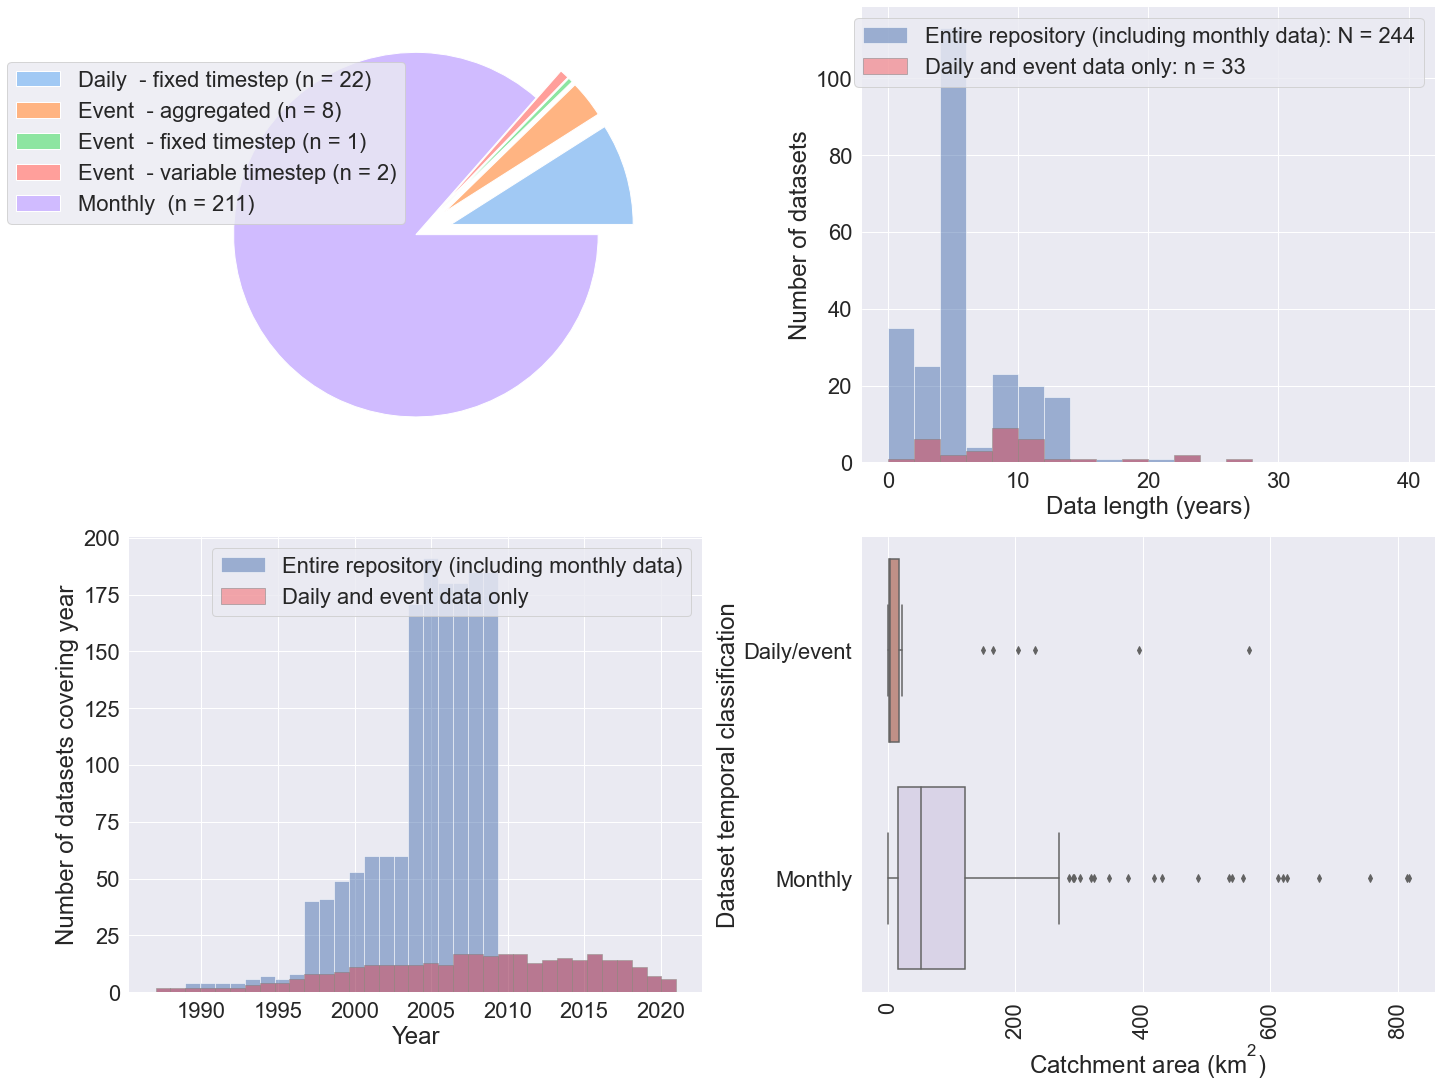

In [27]:
sns.set(font_scale = 2)

f, ax = plt.subplots(2,2,figsize=(20, 15), constrained_layout = True)
dtype_count = dtype_count.replace('data', '', regex = True)
mylabels = dtype_count['Data type'] + ' (n = ' + dtype_count['Catchment ID'].astype(str) + ')'
colors = sns.color_palette('pastel')[0:5]
ex = [0.2, 0.2, 0.2, 0.2, 0]
ax[0,0].pie(dtype_count['Catchment ID'], labels = None,
        explode = ex, colors = colors)
ax[0,0].legend(labels = mylabels, loc = 'lower right', bbox_to_anchor=(0.5, 0.5))


bins = np.arange(0,42,2)
sns.despine(f, left=True, bottom=True)
sns.histplot(x="Data length (years)", linewidth=0.5, data=md_all, bins = bins, alpha = 0.5,
             common_bins = True, ax=ax[0,1], label = 'Entire repository (including monthly data): N = ' + str(len(md_all))) 
sns.histplot(x="Data length (years)", linewidth=0.5, data=md_all_highres, bins = bins, edgecolor = '.5',
             common_bins = True, ax=ax[0,1], color = 'red', alpha = 0.3, label = 'Daily and event data only: n = ' +  str(len(md_all_highres))) 
#ax[0,1].set_title('Data record length distribution')
ax[0,1].set_ylabel('Number of datasets')
ax[0,1].legend()


sns.despine(f, left=True, bottom=True)
sns.histplot(x="year", linewidth=0.5, data=unique_years_all, bins = len(unique_years_all['year'].unique()), alpha = 0.5, 
             ax=ax[1,0], label = 'Entire repository (including monthly data)')
sns.histplot(x="year", linewidth=0.5, data=unique_years_highres, bins = len(unique_years_highres['year'].unique()), edgecolor = '.5',
             ax=ax[1,0], color = 'red', alpha = 0.3, label = 'Daily and event data only')    
plt.xticks(rotation=90)
#ax[1,0].set_title('Temporal coverage')
ax[1,0].set_ylabel('Number of datasets covering year')
ax[1,0].set_xlabel('Year')
ax[1,0].legend()


sns.despine(f, left=True, bottom=True)
sns.boxplot(data=md_all, x="Drainage area km2", y="Temporal classification", 
               palette = ['tomato', colors[4]], saturation = 0.3, ax = ax[1,1])
#ax[1,1].set_title('Catchment drainage area distribution')
ax[1,1].set_ylabel('Dataset temporal classification')
ax[1,1].set_xlabel('Catchment area ($\mathregular{km^{2}}$)')

Below we can plot some attributes of each catchment. This gives the elevation of the monitoring station, the yearly average precipitation and and the spread of the coverage of each land use type in the database.

Text(0.5, 0, 'Land use type')

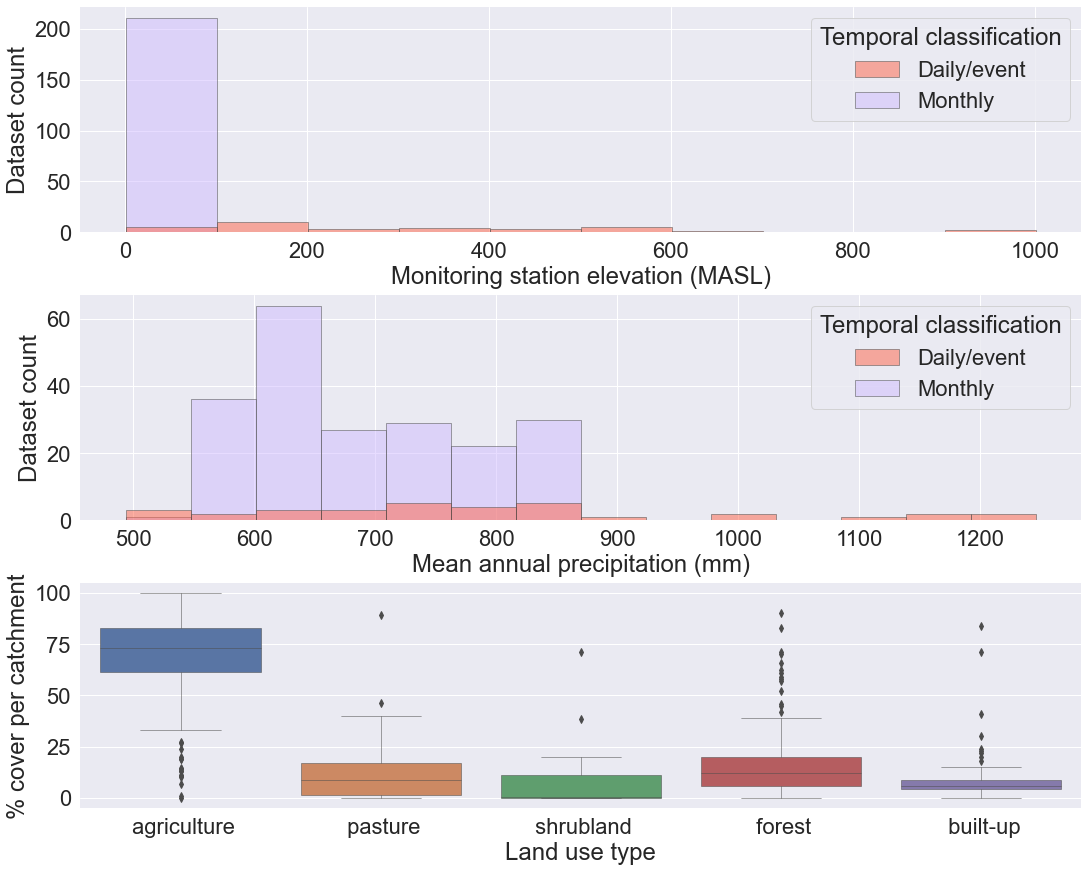

In [28]:
f, ax = plt.subplots(3,1,figsize=(15, 12), constrained_layout = True)
sns.despine(f, left=True, bottom=True)
sns.histplot(x="Elevation (m)", data=md_all, hue = 'Temporal classification', alpha = 0.5,
             edgecolor=".3", linewidth=.5, binwidth = 100, palette = ['tomato', colors[4]], ax=ax[0]) 
ax[0].set_ylabel('Dataset count')
ax[0].set_xlabel('Monitoring station elevation (MASL)')


sns.histplot(x="precip (mm)", data=md_all, hue = 'Temporal classification', alpha = 0.5,
             edgecolor=".3", linewidth=.5, palette = ['tomato', colors[4]], ax=ax[1])
ax[1].set_ylabel('Dataset count')
ax[1].set_xlabel('Mean annual precipitation (mm)')

lc_pcnt = pd.melt(md_all, id_vars = ['Catchment name'], value_vars = ['Land use: % agriculture', 'Land use: % pasture', 'Land use: % shrubland', 'Land use: % forest',
'Land use: % built-up'], var_name = 'Landuse type')
lc_pcnt['Landuse type'] = lc_pcnt['Landuse type'].replace('Land use: %', '', regex = True)

sns.boxplot(x="Landuse type", y = 'value', data= lc_pcnt,
             linewidth=.5, ax = ax[2])
ax[2].set_ylabel('% cover per catchment')
ax[2].set_xlabel('Land use type')

Now we call the plotting functions to to investigate the relationship between annual average specific sediment yield (SSY) and catchment drainage area (A), as well as between suspended sediment yield and discharge. Firstly we can see the slight inverse relationship between SSY and A, but with significant variance in small catchments which likely relates to the magnitude of erosion processes. Secondly we see the control of the hydrological cycle on the sediment yield. 

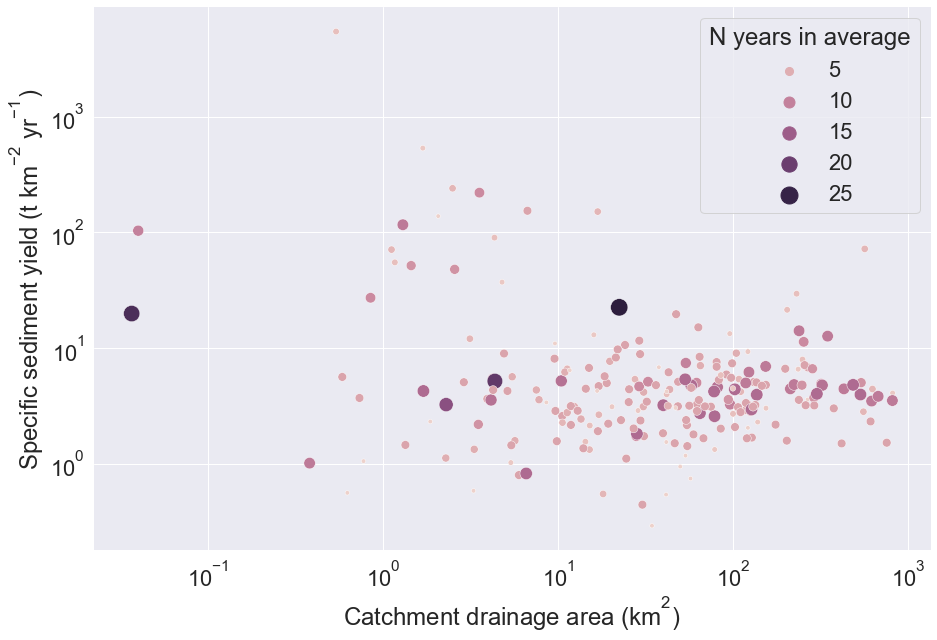

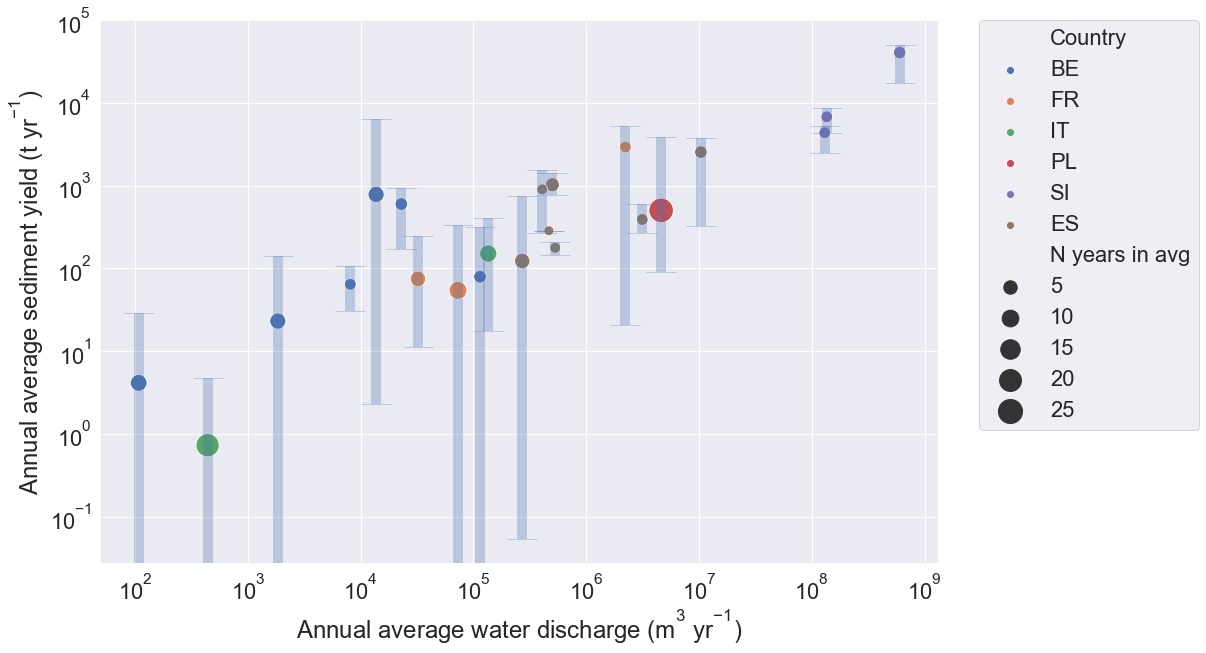

In [29]:
plot_sedY_vs_area(md_all, 'N years in avg')
plot_sedY_vs_Q(md_all_highres, 'Country', 'N years in avg')

# Importing and plotting data from individual catchments

After some database-wide intercomparisons we can focus on extracting some overview statistics from a single time series of a catchment of interest. This part of the tutorial intends to show how one catchment can be easily extracted from the database and some operations can be performed on it. If we print a table of the neccessary columns in the metadata overview we can get information on the ID, name and other details of each catchment contained in EUSEDcollab in order to select a catchment of interest:

In [30]:
display(md_all[['Catchment ID', 'Catchment name', 'Country', 'Relevant references with full details']].head(20))

,Catchment ID,Catchment name,Country,Relevant references with full details
0,1,Chastre-P1,BE,"Cantreul, V., Pineux, N., Swerts, G., Bielders..."
1,2,Chastre-P2,BE,"Cantreul, V., Pineux, N., Swerts, G., Bielders..."
2,3,Chastre-P3,BE,"Cantreul, V., Pineux, N., Swerts, G., Bielders..."
3,4,Chastre-P4,BE,"Cantreul, V., Pineux, N., Swerts, G., Bielders..."
4,5,Ganspoel,BE,"van Oost, K., Govers, G., Cerdan, O., Thauré, ..."
5,6,Kinderveld,BE,"van Oost, K., Govers, G., Cerdan, O., Thauré, ..."
6,7,Nucice,CZ,"Li, T.; Jeřábek, J.; Noreika, N.; Dostál, T.; ..."
7,8,BRVL,FR,"Grangeon, T., Vandromme, R., Pak, L. T., Marti..."
8,9,FDTL,FR,"Grangeon, T., Vandromme, R., Pak, L. T., Marti..."
9,10,Pommeroye,FR,"Patault, E., Alary, C., Franke, C., Gauthier, ..."


Next lets read the EUSEDcollab database in its entirety using the provided .pickle file so we can conveniently access all time series data based on the name (key). The pickle file contains a dictionary of all time series dataframes containing the discharge and suspended sediment data.

In [31]:
all_catchments_ts = pd.read_pickle('all_timeseries.pickle') 

Now we can easily select a catchment and start visualising the data. Let's start with the Kinderveld catchment which is a small monitored watershed in the loamy region of Flanders, Belgium. For every catchment entry, the literature references can be accessed within the metadata to give the citable studies and provide background information on the specific catchment.  


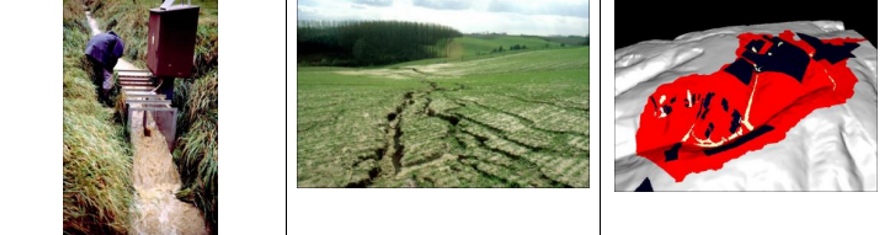

Cantreul, V., Pineux, N., Swerts, G., Bielders, C., & Degré, A. (2020). Performance of the LandSoil expert-based model to map erosion and sedimentation: application to a cultivated catchment in central Belgium. Earth Surface Processes and Landforms, 45(6), 1376–1391. https://doi.org/10.1002/ESP.4808
 
 Pineux, N., Michel, B., Legrain, X., Bielders, C. L., Degré, A., & Colinet, G. (2017). Diachronic soil surveys: A method for quantifying long-term diffuse erosion? Geoderma Regional, 10, 102–114. https://doi.org/10.1016/J.GEODRS.2017.06.001


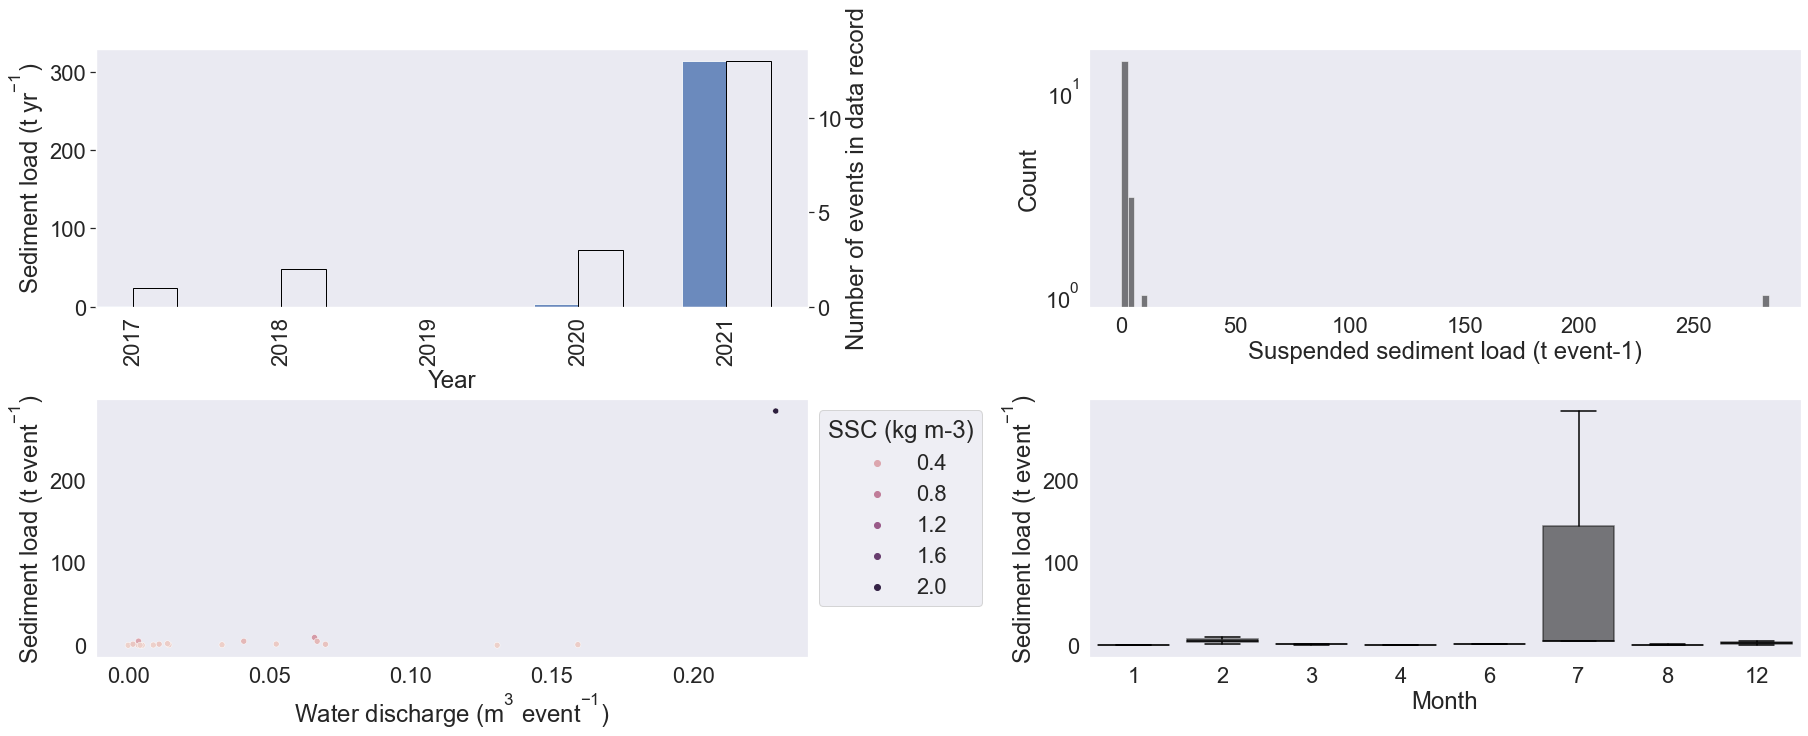

In [32]:
ID = 3
key = f'ID_{ID}'
ts = all_catchments_ts[key]
print(str(md_all[md_all['Catchment ID'] == ID]['Relevant references with full details'].values[0]).replace(';', '\n \n'))
data_format = str(md_all[md_all['Catchment ID'] == ID]['Data type'].values[0])
name = str(md_all[md_all['Catchment ID'] == ID]['Catchment name'].values[0])
generate_catchment_plots(ts, data_format = data_format)

Now we can generate plots for more datasets within the catchment and print the accompanying literature that goes with them. By changing the 'ID' variable, a different catchment can be extracted from the database each time and plotted. 

van Oost, K., Govers, G., Cerdan, O., Thauré, D., van Rompaey, A., Steegen, A., Nachtergaele, J., Takken, I., & Poesen, J. (2005). Spatially distributed data for erosion model calibration and validation: The Ganspoel and Kinderveld datasets. CATENA, 61(2–3), 105–121. https://doi.org/10.1016/J.CATENA.2005.03.001
 
 Steegen, A., & Govers, G. (2001). Correction factors for estimating suspended sediment export from loess catchments. Earth Surface Processes and Landforms, 26(4), 441–449. https://doi.org/10.1002/ESP.196
 
 Steegen, A., Govers, G., Takken, I., Nachtergaele, J., Poesen, J., & Merckx, R. (2001). Factors Controlling Sediment and Phosphorus Export from Two Belgian Agricultural Catchments. Journal of Environmental Quality, 30(4), 1249–1258. https://doi.org/10.2134/JEQ2001.3041249X
 
 Steegen, A., Govers, G., Nachtergaele, J., Takken, I., Beuselinck, L., & Poesen, J. (2000). Sediment export by water from an agricultural catchment in the Loam Belt of central Belgium. Geomorphology, 

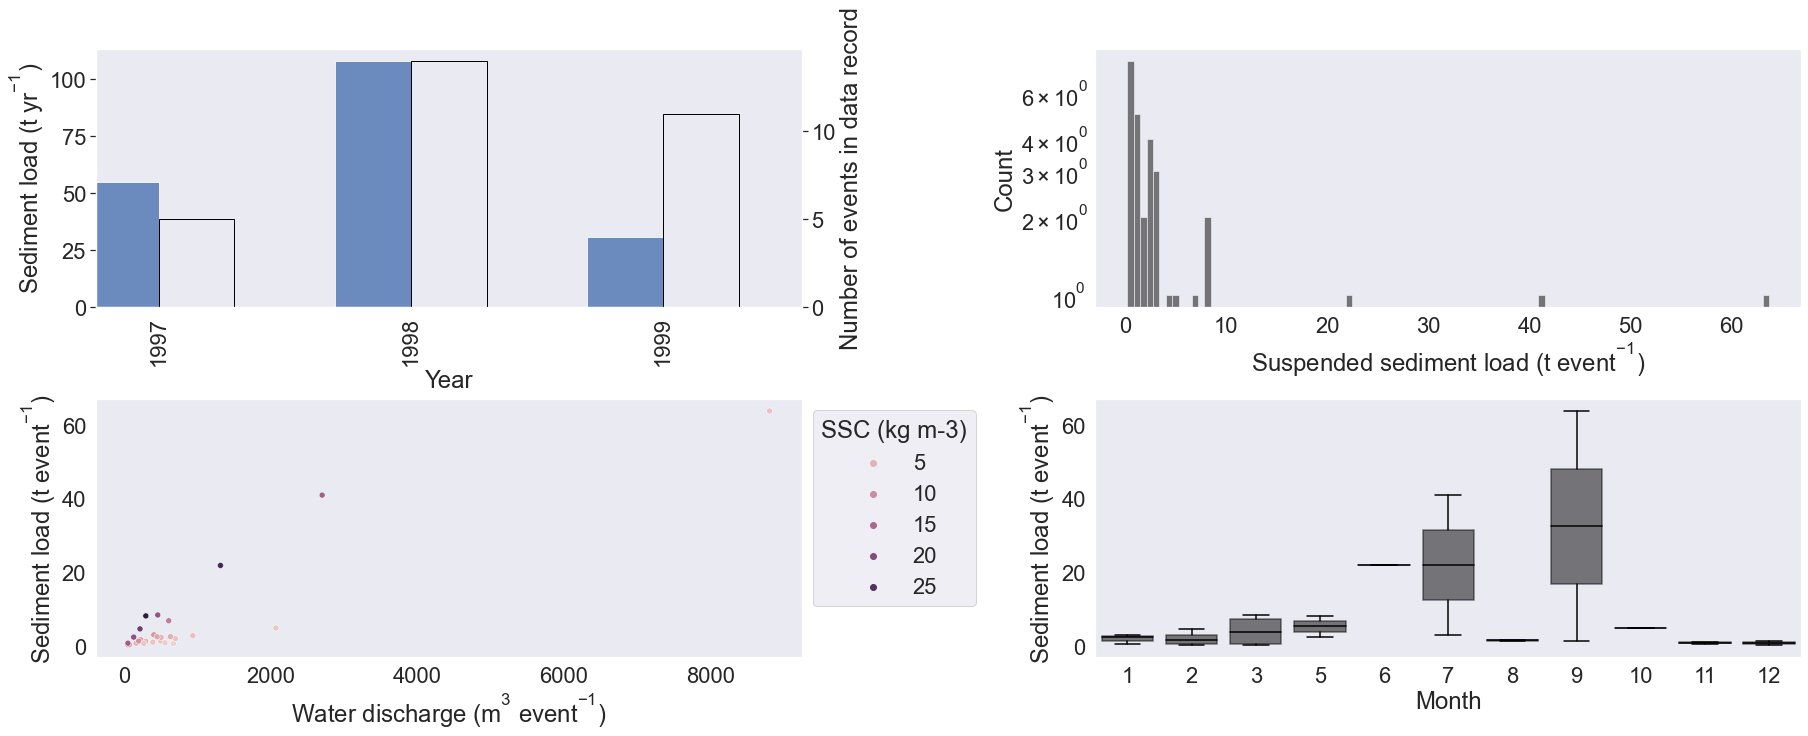

In [33]:
ID = 5
key = f'ID_{ID}'
ts = all_catchments_ts[key]
print(str(md_all[md_all['Catchment ID'] == ID]['Relevant references with full details'].values[0]).replace(';', '\n \n'))
data_format = str(md_all[md_all['Catchment ID'] == ID]['Data type'].values[0])
name = str(md_all[md_all['Catchment ID'] == ID]['Catchment name'].values[0])
generate_catchment_plots(ts, data_format = data_format)

Li, T.
 
 Jeřábek, J.
 
 Noreika, N.
 
 Dostál, T.
 
 Zumr, D. An overview of hydrometeorological datasets from a small agricultural catchment (Nučice) in the Czech Republic, Hydrological Processes. 2021, 35(2), ISSN 1099-1085. 
 
 Zumr, D.
 
 Dostál, T.
 
 Devátý, J.
 
 Valenta, P.
 
 Rosendorf, P.
 
 Eder, A.
 
 Strauss, P. Experimental determination of the flood wave transformation and the sediment resuspension in a small regulated stream in an agricultural catchment, Hydrology and Earth System Sciences. 2017, 21(11), 5681-5691. ISSN 1027-5606. 
 
  Zumr, D.
 
 Dostál, T.
 
 Devátý, J. Identification of prevailing storm runoff generation mechanisms in an intensively cultivated catchment, Journal of Hydrology and Hydromechanics. 2015, 63(3), 246-254. ISSN 0042-790X.


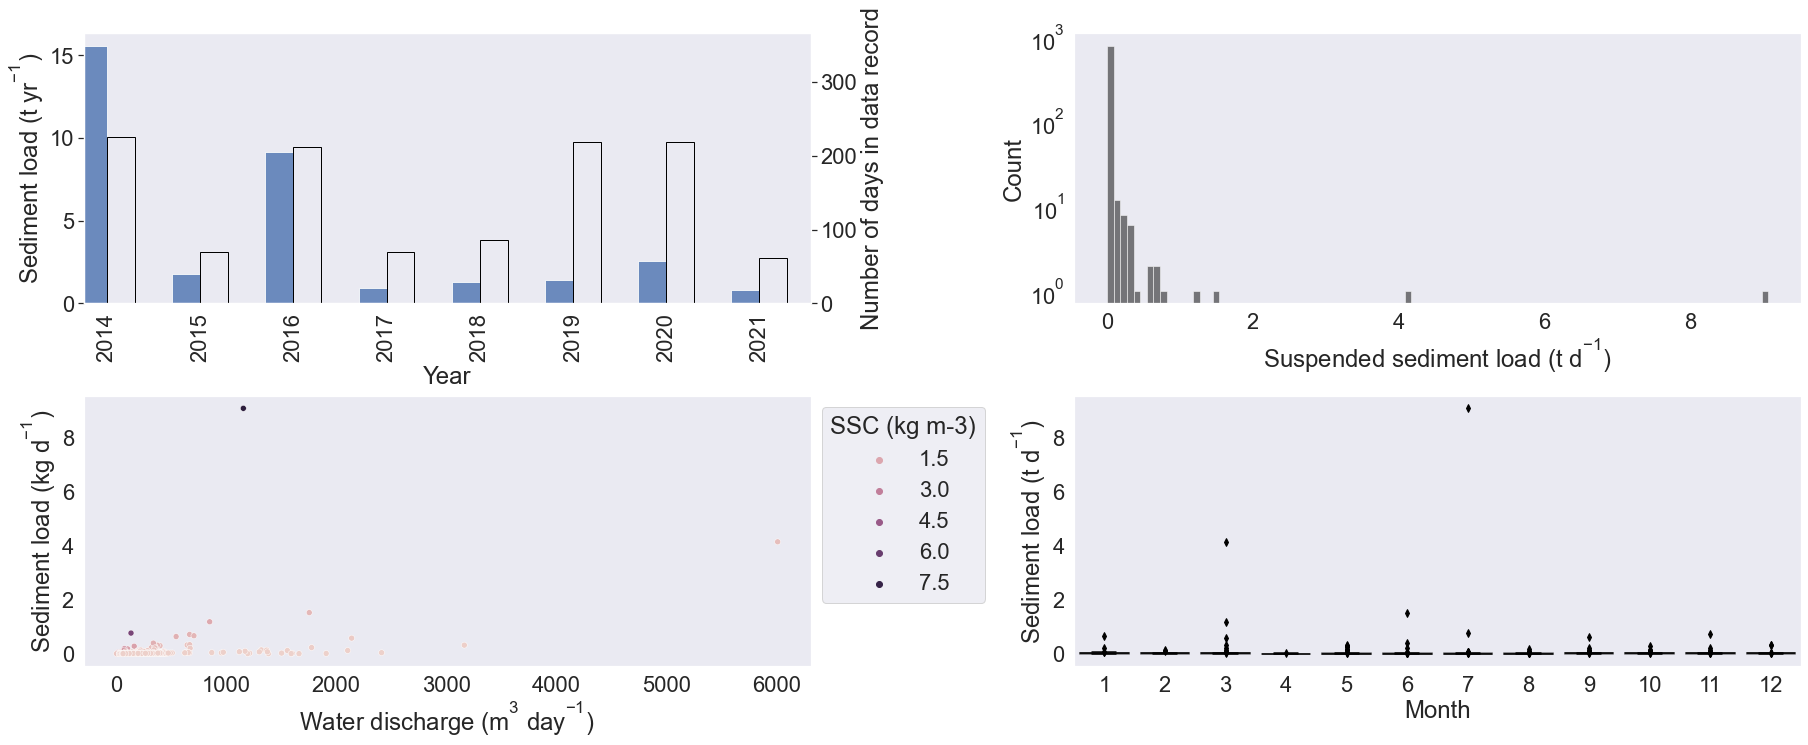

In [34]:
ID = 7
key = f'ID_{ID}'
ts = all_catchments_ts[key]
print(str(md_all[md_all['Catchment ID'] == ID]['Relevant references with full details'].values[0]).replace(';', '\n \n'))
data_format = str(md_all[md_all['Catchment ID'] == ID]['Data type'].values[0])
name = str(md_all[md_all['Catchment ID'] == ID]['Catchment name'].values[0])
generate_catchment_plots(ts, data_format = data_format)

Święchowicz J. The Influence Of Plant Cover And Land Use On Slope–Channel Decoupling In A Foothill Catchment: A Case Study From The Carpathian Foothills, Southern Poland. Earth Surf Process Landf 27(5): 463–479 (2002)
 
 Święchowicz J. Linkage Of Slope Wash And Sediment And Solute Export From A Foothill Catchment In The Carpathian Foothills Of South Poland. Earth Surf Process Landf 27(12): 1389–1413 (2002).


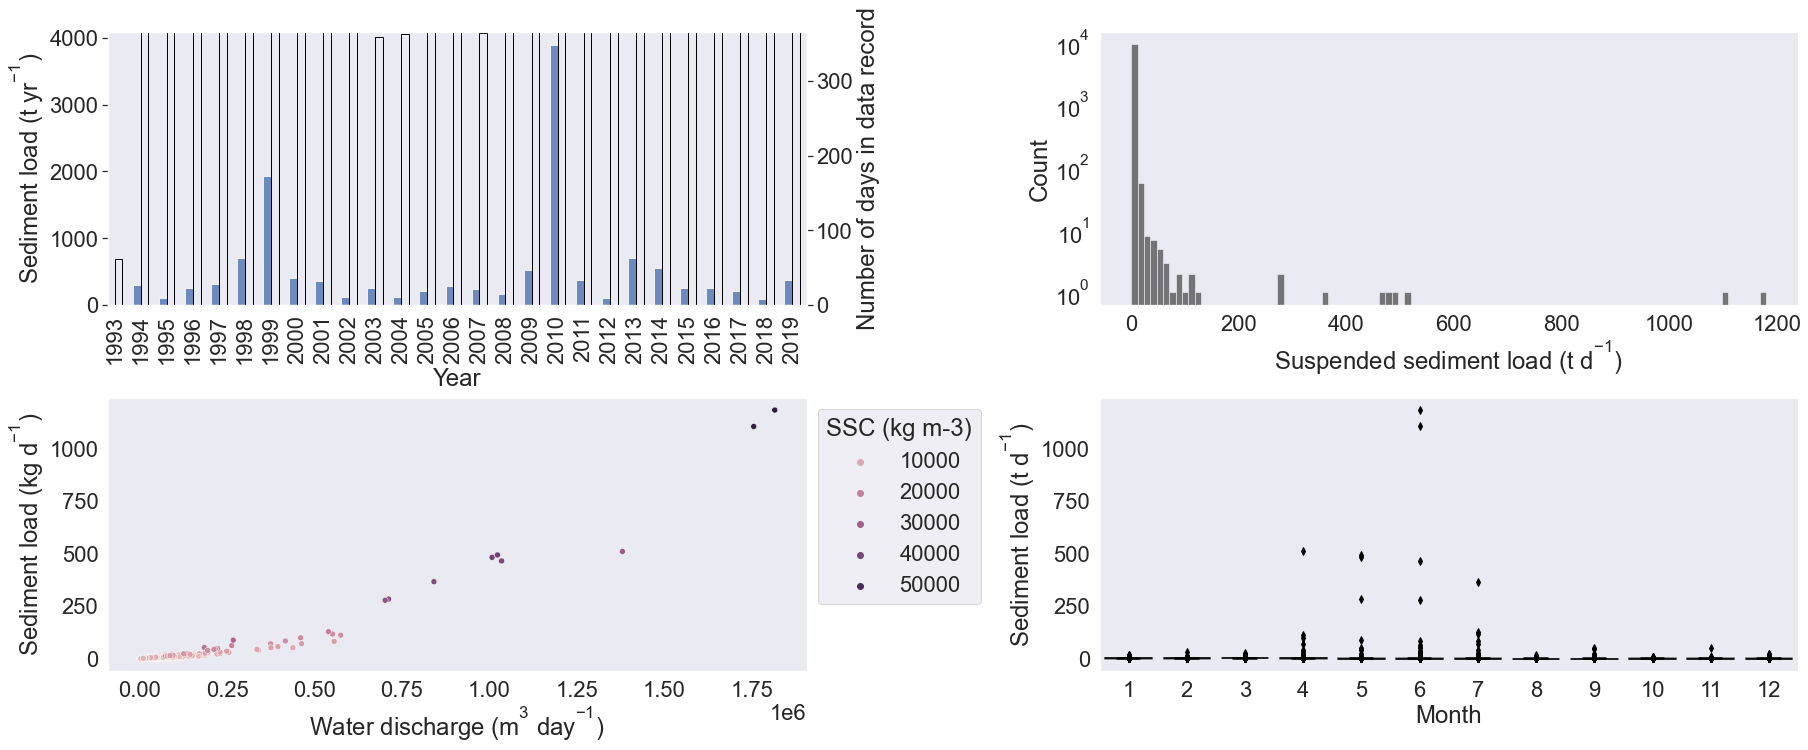

In [35]:
ID = 20
key = f'ID_{ID}'
ts = all_catchments_ts[key]
print(str(md_all[md_all['Catchment ID'] == ID]['Relevant references with full details'].values[0]).replace(';', '\n \n'))
data_format = str(md_all[md_all['Catchment ID'] == ID]['Data type'].values[0])
name = str(md_all[md_all['Catchment ID'] == ID]['Catchment name'].values[0])
generate_catchment_plots(ts, data_format = data_format)

Casalí, J., Giménez, R., Díez, J., Álvarez-Mozos, J., Del Valle de Lersundi, J., Goñi, M., Campo, M.A., Chahor, Y., Gastesi, R. & López, J. 2010, "Sediment production and water quality of Catchments with contrasting land use in Navarre (Spain)", Agricultural Water Management, vol. 97, no. 10, pp. 1683-1694. 
 
 Merchán, D., Luquin, E., Hernández-García, I., Campo-Bescós, M.A., Giménez, R., Casalí, J. & Del Valle de Lersundi, J. 2019, "Dissolved solids and suspended sediment dynamics from five small agricultural Catchments in Navarre, Spain: A 10-year study", Catena, vol. 173, pp. 114-130.


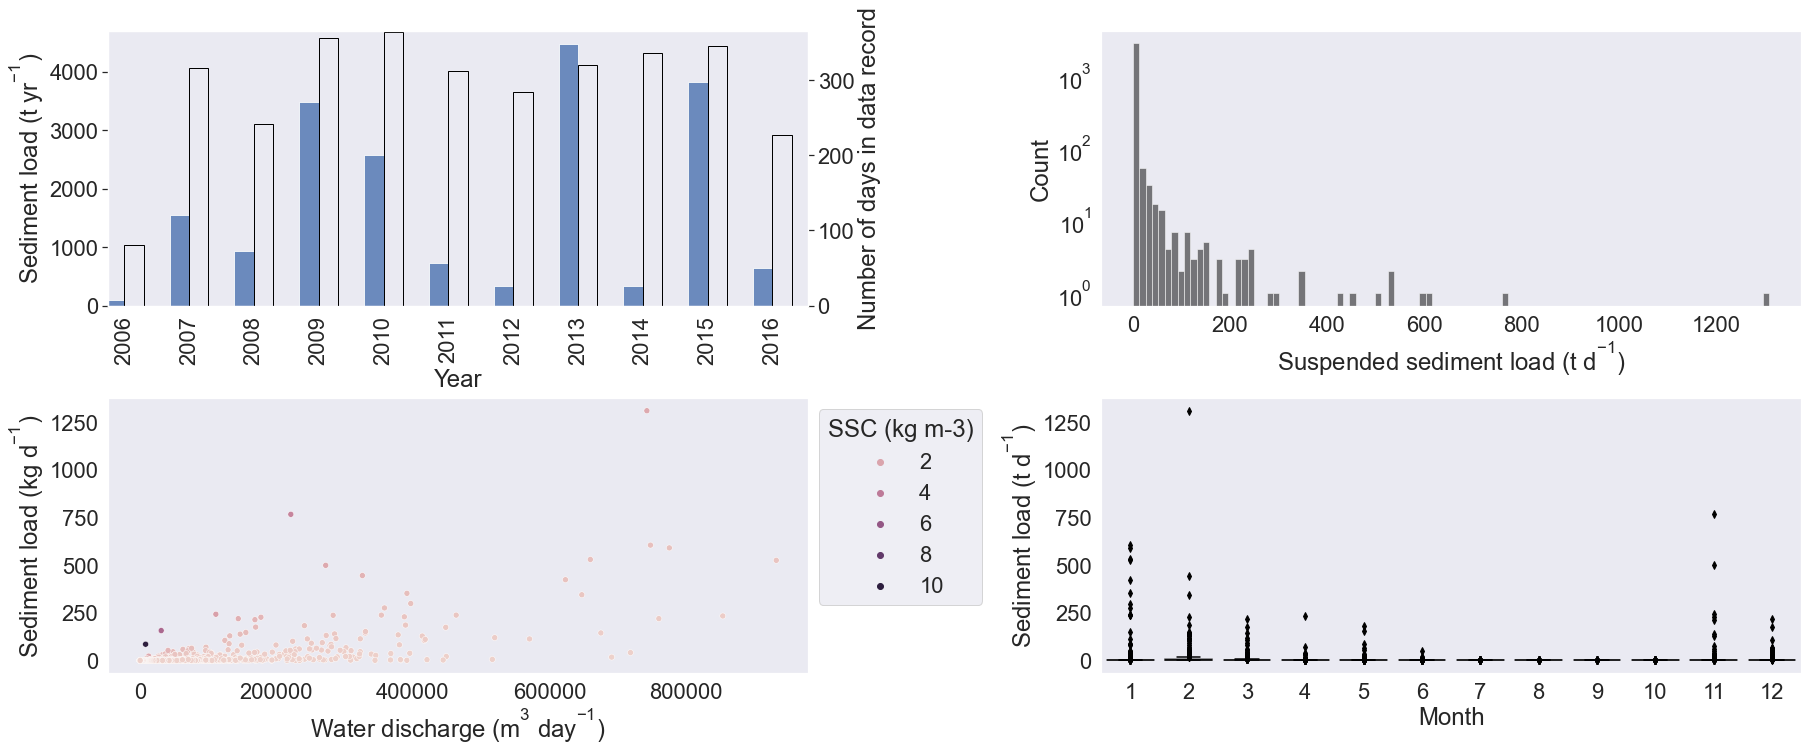

In [36]:
ID = 32
key = f'ID_{ID}'
ts = all_catchments_ts[key]
print(str(md_all[md_all['Catchment ID'] == ID]['Relevant references with full details'].values[0]).replace(';', '\n \n'))
data_format = str(md_all[md_all['Catchment ID'] == ID]['Data type'].values[0])
name = str(md_all[md_all['Catchment ID'] == ID]['Catchment name'].values[0])
generate_catchment_plots(ts, data_format = data_format)